### Build a DNN for ECG Signal Classification (5 classes)  - Pytorch
This is the implementation of an MLP for classifying the ECG signals. <br>
Your task is to design new DNNs for ECG signal classification <br>
You can use this file as a template

In [63]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import torch.optim as optim

## The Neural Network: MLP  (Replace this with your network and rename the file)

In [64]:
class Net(nn.Module):
    def __init__(self, in_channel=1, num_classes=5): 
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=3, stride=2, padding=0)
        self.conv4 = nn.Conv1d(64, 64, kernel_size=3, stride=2, padding=1)  
        self.conv5 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=0)  

        # Normalization layers
        self.norm3 = nn.BatchNorm1d(64)
        self.norm4 = nn.BatchNorm1d(64)
        self.norm5 = nn.BatchNorm1d(64)
        
        # Pooling layers
        self.avg1 = nn.AvgPool1d(kernel_size=2, stride=2, padding=0)
        self.avg2 = nn.AvgPool1d(kernel_size=2, stride=2, padding=0)
        self.avg3 = nn.AvgPool1d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(11840, 10)
        self.fc2 = nn.Linear(10, num_classes)

    def forward(self, x):
        # Apply layers with residual connections
        x1=nnF.relu(self.conv1(x))
        print('x1', x1.shape)
        x2c=nnF.relu(self.conv2(x1))
        print('x2c', x2c.shape)
        x1a=self.avg1(x1)
        print('x1a', x1a.shape)
        x2=x2c+x1a
        print('x2', x2.shape)
        x3c= nnF.relu(self.norm3(self.conv3(x2)))
        print ('x3c', x3c.shape)
        x2a=self.avg2(x2)
        print('x2a', x2.shape)
        x3=x3c+x2a
        print('x3', x3.shape)
        x4c= nnF.relu(self.norm4(self.conv4(x3)))
        print ('x4c', x4c.shape)
        x3a=self.avg3(x3)
        print ('x3a', x3a.shape)
        x4=x4c+x3a
        print ('x4', x4.shape)
        x5= nnF.relu((self.norm5(self.conv5(x1))))
        
        # Flatten the tensor for the dense layers
        x_flat = x5.view(x5.size(0), -1)
        #x=x.reshape(-1,1,187)
       
        # Dense layers with ReLU activation
        x6 = nnF.relu(self.fc1(x_flat))
        z = self.fc2(x6)

        # Apply softmax to the final output
        y_hat = nnF.softmax(z, dim=1)
        #return y_hat
        return z

In [65]:
#debug your network here
#make sure it works for one single input sample
model=Net()
#x=torch.rand(1,187) # x=torch.rand(2,187) with batch_size =2 if using BatchNorm
x=torch.rand(10,1,187) #if network is CNN
z=model(x)

x1 torch.Size([10, 64, 187])
x2c torch.Size([10, 64, 93])
x1a torch.Size([10, 64, 93])
x2 torch.Size([10, 64, 93])
x3c torch.Size([10, 64, 46])
x2a torch.Size([10, 64, 93])
x3 torch.Size([10, 64, 46])
x4c torch.Size([10, 64, 23])
x3a torch.Size([10, 64, 23])
x4 torch.Size([10, 64, 23])


In [66]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

In [67]:
def cal_accuracy(confusion):
    #input: confusion is the confusion matrix
    #output: acc is the standard classification accuracy
    M=confusion.copy().astype('float32')
    acc = M.diagonal().sum()/M.sum()    
    sens=np.zeros(M.shape[0])
    prec=np.zeros(M.shape[0]) 
    for n in range(0, M.shape[0]):
        TP=M[n,n]
        FN=np.sum(M[n,:])-TP
        FP=np.sum(M[:,n])-TP
        sens[n]=TP/(TP+FN)
        prec[n]=TP/(TP+FP)       
    return acc, sens, prec

## The function to train the model

In [68]:
def train(model, device, optimizer, dataloader, epoch):    
    model.train()#set model to training mode
    loss_train=0
    acc_train =0 
    sample_count=0
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()#clear grad of each parameter
        Z = model(X)#forward pass
        loss = nnF.cross_entropy(Z, Y)
        loss.backward()#backward pass
        optimizer.step()#update parameters
        loss_train+=loss.item()
        #do not need softmax
        Yp = Z.data.max(dim=1)[1]  # get the index of the max               
        acc_train+= torch.sum(Yp==Y).item()
        sample_count+=X.size(0)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    #due to upsampling, len(dataloader.dataset) != sample_count
    #acc_train/=len(dataloader.dataset) 
    acc_train/=sample_count    
    return loss_train, acc_train

## The Function to test the model

In [69]:
def test(model, device, dataloader):
    model.eval()#set model to evaluation mode
    acc_test =0
    confusion=np.zeros((5,5))
    with torch.no_grad(): # tell Pytorch not to build graph in the with section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass
            #do not need softmax
            Yp = Z.data.max(dim=1)[1]  # get the index of the max 
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 5):
                for j in range(0, 5):
                    confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    acc, sens, prec=cal_accuracy(confusion)
    return acc, (confusion, sens, prec)

## Load data and create dataloaders

In [70]:
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y
    def __len__(self):
        #return the number of data points
        return self.X.shape[0]
    def __getitem__(self, idx):        
        #we can use DatasetName[idx] to get a data point (x,y) with index idx
        x=torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.Y[idx], dtype=torch.int64)
        x=x.reshape(1,-1)  # if network is CNN
        return x, y

In [71]:
import pandas as pd
X=pd.read_csv('ECG_dataX.csv')
Y=pd.read_csv('ECG_dataY.csv')

In [72]:
#convert dataframe to numpy array
X=X.values
X.shape

(3841, 187)

In [73]:
#convert dataframe to numpy array
Y=Y.values
Y.shape

(3841, 1)

In [74]:
#reshape Y into a 1D array
Y=Y.reshape(-1)
Y.shape

(3841,)

(array([800.,   0., 800.,   0.,   0., 800.,   0., 641.,   0., 800.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

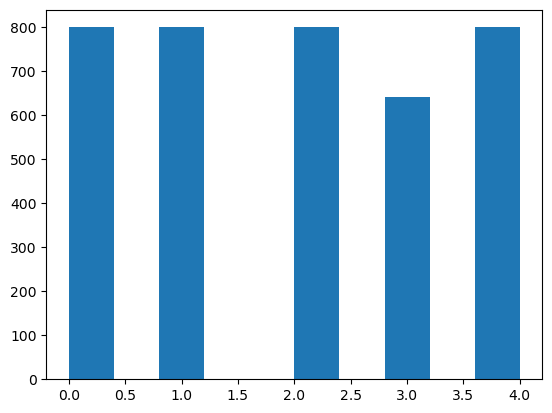

In [75]:
plt.hist(Y)

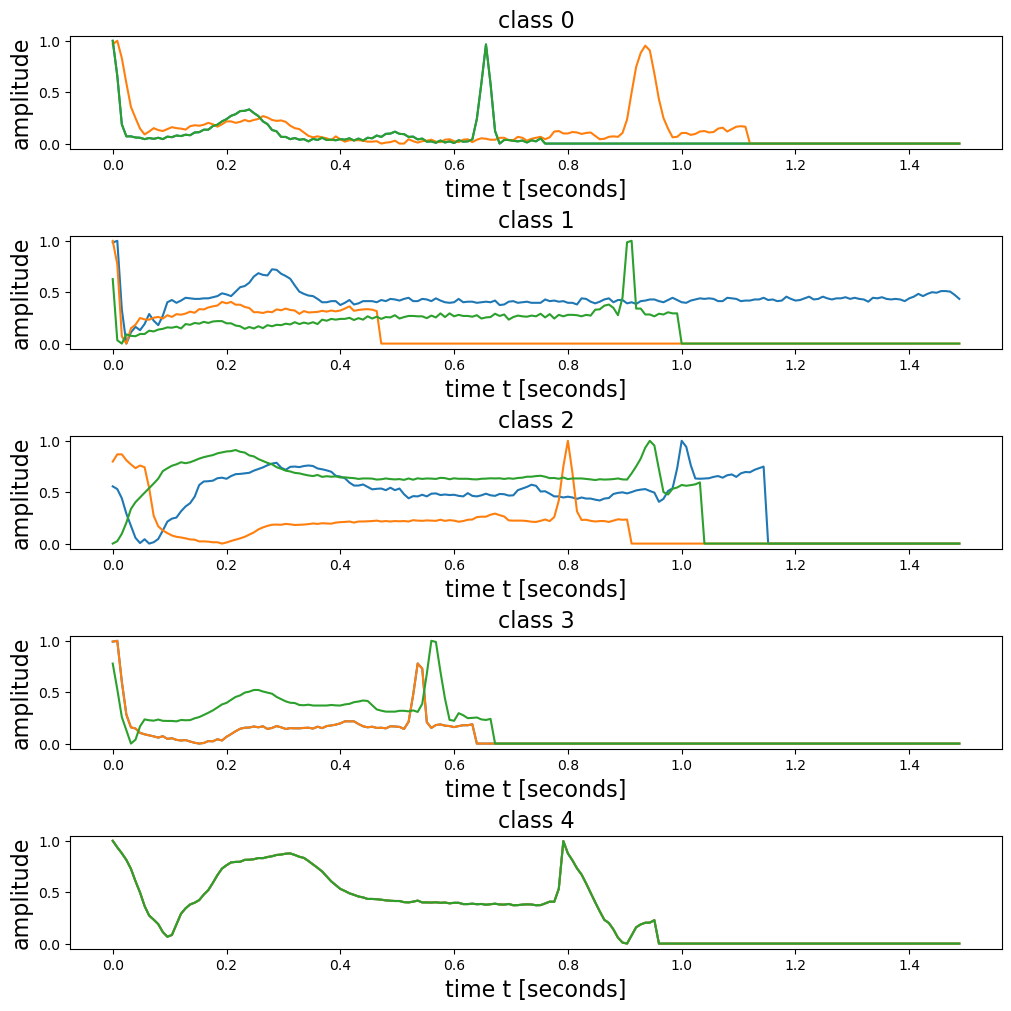

In [76]:
fs=125  # sampling frequency
Ts=1/fs # sampling interval
N=187 # the number of timepoints
Duration=N*Ts # duration of a signal
t=np.linspace(0, Duration-Ts, N) # array of timepoints
fig, ax = plt.subplots(5,1,constrained_layout=True, figsize=(10,10))
for c in range(0, 5):   
    for n in range(0, 3):
        idx=np.random.randint(0,10)
        ax[c].plot(t, X[Y==c][idx])        
        ax[c].set_xlabel('time t [seconds]', fontsize=16)
        ax[c].set_ylabel('amplitude', fontsize=16)
    ax[c].set_title('class '+str(c), fontsize=16)

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

In [78]:
dataset_train=MyDataset(X_train, Y_train)
dataset_val=MyDataset(X_val, Y_val)
dataset_test=MyDataset(X_test, Y_test)

In [79]:
loader_train = torch_dataloader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
loader_val = torch_dataloader(dataset_val, batch_size=128, shuffle=False, num_workers=0) 
loader_test = torch_dataloader(dataset_test, batch_size=128, shuffle=False, num_workers=0) 

## Create a model, and start the traning-validation-testing process

In [80]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=Net()
model.to(device)
#the code below may cause error if BatchNorm is used, you may delete those without affecting the rest of the file
#x=dataset_train[0][0]
#x=x.view(1,187).to(device) #change it to x=x.view(1,1,187).to(device) for CNN
#z=model(x)

Net(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(2,))
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(2,))
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv5): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (norm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (avg2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (avg3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (fc1): Linear(in_features=11840, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
)

In [81]:
y_hat=nnF.softmax(z, dim=1)
y_hat

tensor([[0.1997, 0.2130, 0.2304, 0.1828, 0.1741],
        [0.1980, 0.1810, 0.2092, 0.1923, 0.2196],
        [0.1694, 0.2192, 0.2204, 0.1998, 0.1912],
        [0.1812, 0.1819, 0.2224, 0.2100, 0.2045],
        [0.1585, 0.2142, 0.2548, 0.1964, 0.1760],
        [0.2012, 0.1698, 0.2533, 0.1903, 0.1854],
        [0.1379, 0.1979, 0.2741, 0.1940, 0.1961],
        [0.1936, 0.2214, 0.2760, 0.1569, 0.1521],
        [0.1770, 0.2103, 0.2060, 0.2140, 0.1927],
        [0.1560, 0.1952, 0.2540, 0.2030, 0.1918]], grad_fn=<SoftmaxBackward0>)

use stochastic gradient descent as the optimization method

In [82]:
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-4)

In [83]:
loss_train_list=[]
acc_train_list=[]
acc_val_list=[]
epoch_save=-1

train/val/test over many epochs

In [84]:
for epoch in range(epoch_save+1, 100): #change 100 to a larger number if necessary
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- validation --------------------------------
    acc_val, other_val = test(model, device, loader_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation acc:', acc_val)
    #--------save model-------------------------
    result = (loss_train_list, acc_train_list, 
              acc_val_list, other_val)
    save_checkpoint('ECG_MLP_Pytorch_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save=epoch

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
Train Epoch: 0 [0%]	Loss: 1.602237
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size

/var/folders/jl/kzj9mlrx3fz83wmz4qsd35gm0000gn/T/ipykernel_64352/3076453557.py:13: RuntimeWarning: invalid value encountered in scalar divide
  prec[n]=TP/(TP+FP)


epoch 0 validation acc: 0.29545453
saved: ECG_MLP_Pytorch_epoch0.pt
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
Train Epoch: 1 [0%]	Loss: 1.254972
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 tor

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128,

x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128,

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128,

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([76, 64, 187])
x2c torch.Size([76, 64, 93])
x1a torch.Size([76, 64, 93])
x2 torch.Size([76, 64, 93])
x3c torch.Size([76, 64, 

epoch 9 training loss: 0.6385186856443231 acc: 0.7793053545586107
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([52, 64, 187])
x2c torch.Size([52, 64, 93])
x1a torch.Size([52, 64, 93])
x2 torch.Size([52, 64, 93])
x3c torch.Size([52, 64, 46])
x2a torch.Size([52, 64, 93])
x3 torch.Size([52, 64, 46])
x4c torch.Size([52, 64, 23])
x3a torch.Size([52, 64, 23])
x4 torch.Size([52, 64, 23])
epoch 9 validation acc: 0.762987
saved: ECG_MLP_Pytor

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
Train Epoch: 11 [0%]	Loss: 0.715962
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Siz

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128,

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128,

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128,

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([76, 64, 187])
x2c torch.Size([76, 64, 93])
x1a torch.Size([76, 64, 93])
x2 torch.Size([76, 64, 93])
x3c torch.Size([76, 64, 46])
x2a torch.Size([76, 64, 93])
x3 torch.Size([76, 64, 46])
x4c torch.Size([76, 64, 23])
x3a torch.Size([76, 64, 23])
x4 torch.Size([76, 64, 23])
epoch 18 training loss: 0.42444430562582885 acc: 0.8317655571635311
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 

epoch 19 training loss: 0.39215257222002203 acc: 0.9044862518089725
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([52, 64, 187])
x2c torch.Size([52, 64, 93])
x1a torch.Size([52, 64, 93])
x2 torch.Size([52, 64, 93])
x3c torch.Size([52, 64, 46])
x2a torch.Size([52, 64, 93])
x3 torch.Size([52, 64, 46])
x4c torch.Size([52, 64, 23])
x3a torch.Size([52, 64, 23])
x4 torch.Size([52, 64, 23])
epoch 19 validation acc: 0.8214286
saved: ECG_MLP_P

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
Train Epoch: 21 [0%]	Loss: 0.301757
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Siz

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128,

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128,

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128,

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128,

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([76, 64, 187])
x2c torch.Size([76, 64, 93])
x1a torch.Size([76, 64, 93])
x2 torch.Size([76, 64, 93])
x3c torch.Size([76, 64, 46])
x2a torch.Size([76, 64, 93])
x3 torch.Size([76, 64, 46])
x4c torch.Size([76, 64, 23])
x3a torch.Size([76, 64, 23])
x4 torch.Size([76, 64, 23])
epoch 28 training loss: 0.17589722844687375 acc: 0.9511577424023154
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 

epoch 29 training loss: 0.16515931588682262 acc: 0.9554992764109985
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([52, 64, 187])
x2c torch.Size([52, 64, 93])
x1a torch.Size([52, 64, 93])
x2 torch.Size([52, 64, 93])
x3c torch.Size([52, 64, 46])
x2a torch.Size([52, 64, 93])
x3 torch.Size([52, 64, 46])
x4c torch.Size([52, 64, 23])
x3a torch.Size([52, 64, 23])
x4 torch.Size([52, 64, 23])
epoch 29 validation acc: 0.8279221
saved: ECG_MLP_P

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
Train Epoch: 31 [0%]	Loss: 0.137371
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128,

x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128,

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([76, 64, 187])
x2c torch.Size([76, 64, 93])
x1a torch.Size([76, 64, 93])
x2 torch.Size([76, 64, 93])
x3c torch.Size([76, 64, 46])
x2a torch.Size([76, 64, 93])
x3 torch.Size([76, 64, 46])
x4c torch.Size([76, 64, 23])
x3a torch.Size([76, 64, 23])
x4 torch.Size([76, 64, 23])
epoch 38 training loss: 0.11028523370623589 acc: 0.9721418234442837
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([52, 64, 187])
x2c torch.Size([52, 64, 93])
x1a torch.Size([52, 64, 93])
x2 torch.Size([52, 64, 93])
x3c torch.Size([52, 64, 46])
x2a torch.Size([52, 64, 93])
x3 torch.Size([52, 64, 46])
x4c torch.Size([52, 64, 23])
x3a torch.Size([52, 64, 23])
x4 torch.Size([52, 64, 23])
epoch 39 validation acc: 0.8603896
saved: ECG_MLP_Pytorch_epoch39.pt
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
Train Epoch: 40 [0%]	Loss: 0.072189
x1 torch.Size(

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
Train Epoch: 41 [0%]	Loss: 0.119995
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size

x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128,

x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128,

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128,

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128,

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([76, 64, 187])
x2c torch.Size([76, 64, 93])
x1a torch.Size([76, 64, 93])
x2 torch.Size([76, 64, 93])
x3c torch.Size([76, 64, 46])
x2a torch.Size([76, 64, 93])
x3 torch.Size([76, 64, 46])
x4c torch.Size([76, 64, 23])
x3a torch.Size([76, 64, 23])
x4 torch.Size([76, 64, 23])
epoch 48 training loss: 0.07113279368389737 acc: 0.9837192474674384
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 6

epoch 49 training loss: 0.07052562081001022 acc: 0.984081041968162
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([52, 64, 187])
x2c torch.Size([52, 64, 93])
x1a torch.Size([52, 64, 93])
x2 torch.Size([52, 64, 93])
x3c torch.Size([52, 64, 46])
x2a torch.Size([52, 64, 93])
x3 torch.Size([52, 64, 46])
x4c torch.Size([52, 64, 23])
x3a torch.Size([52, 64, 23])
x4 torch.Size([52, 64, 23])
epoch 49 validation acc: 0.85064936
saved: ECG_MLP_P

epoch 50 validation acc: 0.8538961
saved: ECG_MLP_Pytorch_epoch50.pt
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
Train Epoch: 51 [0%]	Loss: 0.041086
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 t

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128,

x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128,

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128,

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128,

x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([76, 64, 187])
x2c torch.Size([76, 64, 93])
x1a torch.Size([76, 64, 93])
x2 torch.Size([76, 64, 93])
x3c torch.Size([76, 64, 46])
x2a torch.Size([76, 64, 93])
x3 torch.Size([76, 64, 46])
x4c torch.Size([76, 64, 23]

epoch 59 training loss: 0.04600030403922905 acc: 0.9927641099855282
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([52, 64, 187])
x2c torch.Size([52, 64, 93])
x1a torch.Size([52, 64, 93])
x2 torch.Size([52, 64, 93])
x3c torch.Size([52, 64, 46])
x2a torch.Size([52, 64, 93])
x3 torch.Size([52, 64, 46])
x4c torch.Size([52, 64, 23])
x3a torch.Size([52, 64, 23])
x4 torch.Size([52, 64, 23])
epoch 59 validation acc: 0.8538961
saved: ECG_MLP_P

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
Train Epoch: 61 [0%]	Loss: 0.031640
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128,

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128,

x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 

x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([76, 64, 187])
x2c torch.Size([76, 64, 93])
x1a torch.Size([76, 64, 93])
x2 torch.Size([76, 64, 93])
x3c torch.Size([76, 64, 46])
x2a torch.Size([76, 64, 93])
x3 torch.Size([76, 64, 46])
x4c torch.Size([76, 64, 23])
x3a torch.Size([76, 64, 23])
x4 torch.Size([76, 64, 23])
epoch 68 training loss: 0.0324101329527118 acc: 0.9949348769898697
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 6

epoch 69 training loss: 0.0324124370447614 acc: 0.9952966714905933
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([52, 64, 187])
x2c torch.Size([52, 64, 93])
x1a torch.Size([52, 64, 93])
x2 torch.Size([52, 64, 93])
x3c torch.Size([52, 64, 46])
x2a torch.Size([52, 64, 93])
x3 torch.Size([52, 64, 46])
x4c torch.Size([52, 64, 23])
x3a torch.Size([52, 64, 23])
x4 torch.Size([52, 64, 23])
epoch 69 validation acc: 0.8603896
saved: ECG_MLP_Py

epoch 70 validation acc: 0.83766234
saved: ECG_MLP_Pytorch_epoch70.pt
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
Train Epoch: 71 [0%]	Loss: 0.039193
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128,

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128,

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128,

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128,

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128,

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([76, 64, 187])
x2c torch.Size([76, 64, 93])
x1a torch.Size([76, 64, 93])
x2 torch.Size([76, 64, 93])
x3c torch.Size([76, 64, 46])
x2a torch.Size([76, 64, 93])
x3 torch.Size([76, 64, 46])
x4c torch.Size([76, 64, 23])
x3a torch.Size([76, 64, 23])
x4 torch.Size([76, 64, 23])
epoch 79 training loss: 0.023889909879389135 acc: 0.9963820549927641
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128,

epoch 80 training loss: 0.02224840122190389 acc: 0.9960202604920405
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([52, 64, 187])
x2c torch.Size([52, 64, 93])
x1a torch.Size([52, 64, 93])
x2 torch.Size([52, 64, 93])
x3c torch.Size([52, 64, 46])
x2a torch.Size([52, 64, 93])
x3 torch.Size([52, 64, 46])
x4c torch.Size([52, 64, 23])
x3a torch.Size([52, 64, 23])
x4 torch.Size([52, 64, 23])
epoch 80 validation acc: 0.84415585
saved: ECG_MLP_

epoch 81 validation acc: 0.84090906
saved: ECG_MLP_Pytorch_epoch81.pt
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
Train Epoch: 82 [0%]	Loss: 0.019676
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128,

x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128,

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128,

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([76, 64, 187])
x2c torch.Size([76, 64, 93])
x1a torch.Size([76, 64, 93])
x2 torch.Size([76, 64,

x2c torch.Size([76, 64, 93])
x1a torch.Size([76, 64, 93])
x2 torch.Size([76, 64, 93])
x3c torch.Size([76, 64, 46])
x2a torch.Size([76, 64, 93])
x3 torch.Size([76, 64, 46])
x4c torch.Size([76, 64, 23])
x3a torch.Size([76, 64, 23])
x4 torch.Size([76, 64, 23])
epoch 90 training loss: 0.01682240526530553 acc: 0.9967438494934877
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([52, 64, 187])
x2c torch.Size([52, 64, 93])
x1a torch.Size([52, 64

x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([52, 64, 187])
x2c torch.Size([52, 64, 93])
x1a torch.Size([52, 64, 93])
x2 torch.Size([52, 64, 93])
x3c torch.Size([52, 64, 46])
x2a torch.Size([52, 64, 93])
x3 torch.Size([52, 64, 46])
x4c torch.Size([52, 64, 23])
x3a torch.Size([52, 64, 23])
x4 torch.Size([52, 64, 23])
epoch 91 validation acc: 0.8474026
saved: ECG_MLP_Pytorch_epoch91.pt
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
Train Epoch: 92 [0%]	Loss: 0.014338
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size

Train Epoch: 93 [0%]	Loss: 0.016499
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Siz

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128,

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128,

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128,

x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([76, 64, 187])
x2c torch.Size([76, 64, 93])
x1a torch.Size([76, 64, 93])
x2 torch.Size([76, 64, 93])
x3c torch.Size([76, 64, 46])
x2a torch.Size([76, 64, 93])
x3 torch.Size([76, 64, 46])
x4c torch.Size([76, 64, 23])
x3a torch.Size([76, 64, 23])
x4 torch.Size([76, 64, 23])
epoch 99 training loss: 0.0119

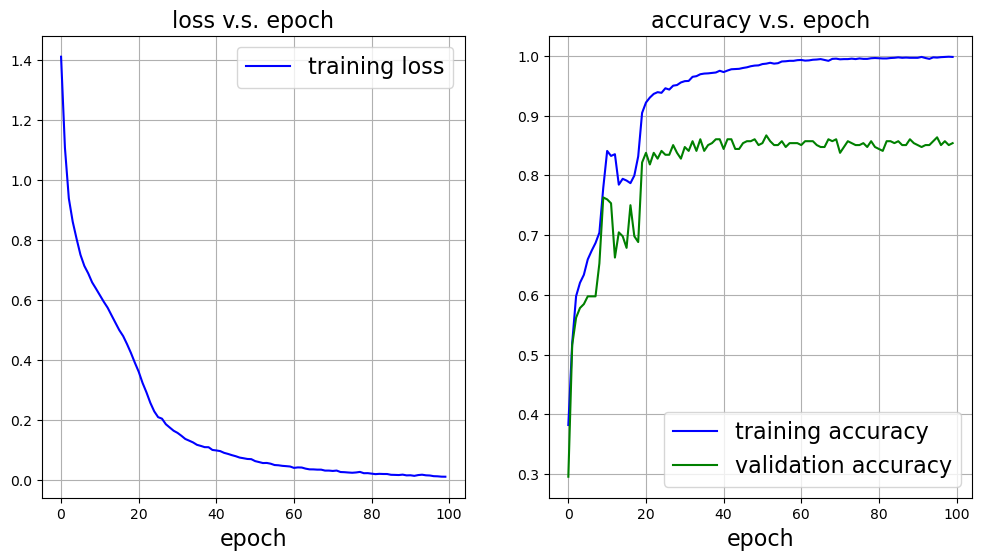

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_title('loss v.s. epoch',fontsize=16)
ax[0].plot(loss_train_list, '-b', label='training loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].set_title('accuracy v.s. epoch',fontsize=16)
ax[1].plot(acc_train_list, '-b', label='training accuracy')
ax[1].plot(acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

load the best model

In [86]:
best_epoch=np.argmax(acc_val_list)
best_epoch

51

In [87]:
checkpoint=torch.load('ECG_MLP_Pytorch_epoch'+str(best_epoch)+'.pt')
model=Net()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device);
model.eval();

In [88]:
acc, (confusion, sens, prec) = test(model, device, loader_test)
print('Accuracy (average)', acc)
print('Sensitivity', sens)
print('Precision', prec)
print('Confusion \n', confusion)

x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128, 64, 93])
x3c torch.Size([128, 64, 46])
x2a torch.Size([128, 64, 93])
x3 torch.Size([128, 64, 46])
x4c torch.Size([128, 64, 23])
x3a torch.Size([128, 64, 23])
x4 torch.Size([128, 64, 23])
x1 torch.Size([128, 64, 187])
x2c torch.Size([128, 64, 93])
x1a torch.Size([128, 64, 93])
x2 torch.Size([128,